# Booking Price prediction for new properties in Airbnb Seattle

The intent of this notebook is to analyse the Airbnb Seattle data for the year 2016-2017, find meaningful insights and predict the booking price for a new property given a date and other factors. As a new property will not be having any reviews, the 'reviews' file has not been used here for the prediction.

The notebook also answers the following business questions:

1. How is the price distribution among all the Airbnb Seattle properties?
2. What are the most expensive/ cheapest neighbourhoods in Seattle?
3. Do some property types cost more than others?
4. How is the property booking per month?
5. Is there a peak season for Airbnb bookings?

**Sections:**
1. Data loading
2. Data analysis
3. Data cleansing
4. Data preparation
5. Model building and evaluation

## 1. Data loading

#### Importing the required libraries

In [1]:
# Libraries for data pre-processing
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None) # Setting to display all the pandas columns

In [3]:
# Libraries for modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Libraries for model evaluation
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Load the file required files

In [6]:
calendar =pd.read_csv('calendar.csv')
listings =pd.read_csv('listings.csv')

#### Initial analysis

In [7]:
listings.shape # To check the number of rows and columns in the listings file

(3818, 92)

In [8]:
calendar.shape # To check the number of rows and columns in the calendar file

(1393570, 4)

In [9]:
len(set(calendar['listing_id'])) # To check the number of unique listing_ids in the calendar file

3818

In [10]:
calendar['date'].min()    # Earliest booking date

'2016-01-04'

In [11]:
calendar['date'].max() # Last booking date

'2017-01-02'

In [12]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [13]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [14]:
calendar.isnull().sum()         # To find the total nulls in the calendar file

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [15]:
# To find all the columns with null values in the listings file
nullseries = (listings.isnull().sum()/ listings.shape[0] * 100).sort_values(ascending=False)
print(nullseries[nullseries > 0])

license                        100.000000
square_feet                     97.459403
monthly_price                   60.267156
security_deposit                51.126244
weekly_price                    47.380828
notes                           42.063908
neighborhood_overview           27.029859
cleaning_fee                    26.977475
transit                         24.463070
host_about                      22.498690
host_acceptance_rate            20.246202
review_scores_accuracy          17.234154
review_scores_checkin           17.234154
review_scores_value             17.181771
review_scores_location          17.155579
review_scores_cleanliness       17.103195
review_scores_communication     17.050812
review_scores_rating            16.946045
reviews_per_month               16.422211
first_review                    16.422211
last_review                     16.422211
space                           14.903091
host_response_time              13.698271
host_response_rate              13

## 2. Data analysis

### Calendar file

In [16]:
# Make a subset of all the dates when the properties are booked
# This data can be used to make some insights on the booked properties

calendar_booked = calendar[calendar['available']=='f']
set(calendar_booked['available'])

{'f'}

In [17]:
# Drop records which do not have any booking price
calendar = calendar[calendar['available']=='t']
set(calendar['available'])

{'t'}

In [18]:
calendar= calendar.rename(columns={'price': 'target'}) # Rename 'price' column to 'target'

# Convert Price to numeric
calendar['target']  = calendar['target'].replace('[\$,]', '', regex=True).astype(float)
calendar['target']  = calendar['target'].astype('int')

Text(0.5, 0, 'Booking price')

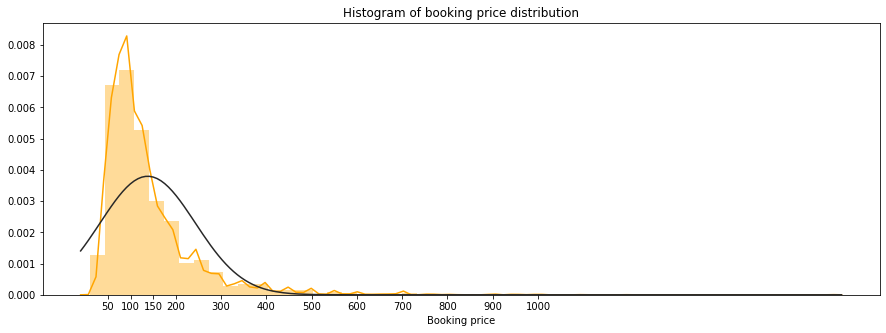

In [19]:
# Histogram of booking price distribution
plt.rcParams["figure.figsize"] = (15,5)
sns.distplot(calendar['target'] , fit=norm, color='orange')
x = [50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
plt.xticks(x)
plt.title('Histogram of booking price distribution')
plt.xlabel('Booking price')

### Listings file:

In [20]:
listings = listings.rename(columns={"id": "listing_id"}) # Rename id to listing_id to be in sync with the calendar file

In [21]:
# Convert Price to numeric for plotting
listings['price']  = listings['price'].replace('[\$,]', '', regex=True).astype(float) 
listings['price'] = listings['price'].astype('int')

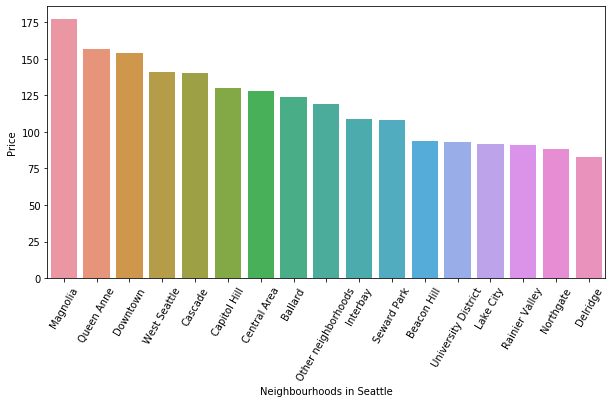

In [22]:
# Plot mean price per neighbourhood group

x = pd.DataFrame(listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False))
x = x.reset_index()
x['price'] = x['price'].astype('int')

plt.rcParams["figure.figsize"] = (10,5)

sns.barplot(x = 'neighbourhood_group_cleansed',
            y = 'price',
            data = x)
plt.xticks(rotation=60)
plt.xlabel('Neighbourhoods in Seattle')
plt.ylabel('Price')
plt.show()

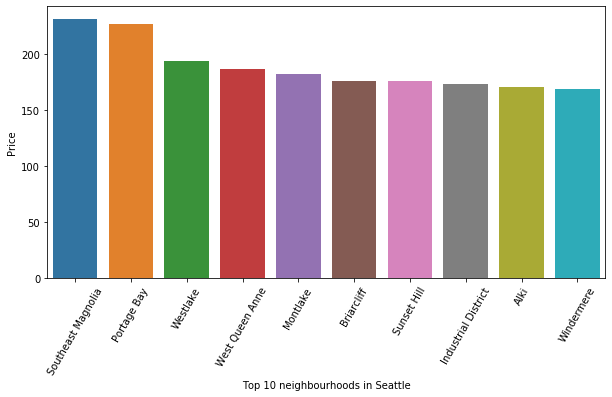

In [23]:
# Plot the top 10 most expensive neighbourhoods

x = pd.DataFrame(listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(10))
x = x.reset_index()
x['price'] = x['price'].astype('int')

plt.rcParams["figure.figsize"] = (10,5)

sns.barplot(x = 'neighbourhood_cleansed',
            y = 'price',
            data = x)
plt.xticks(rotation=60)
plt.xlabel('Top 10 neighbourhoods in Seattle')
plt.ylabel('Price')
plt.show()

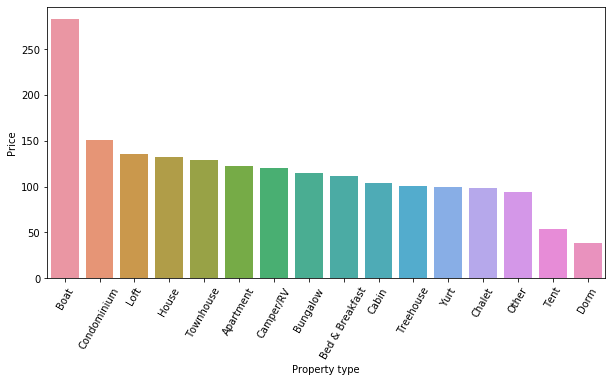

In [24]:
# PLot mean price per Property type
x = pd.DataFrame(listings.groupby('property_type')['price'].mean().sort_values(ascending=False))
x = x.reset_index()
x['price'] = x['price'].astype('int')

plt.rcParams["figure.figsize"] = (10,5)

sns.barplot(x = 'property_type',
            y = 'price',
            data = x)
plt.xticks(rotation=60)
plt.xlabel('Property type')
plt.ylabel('Price')
plt.show()

## 3. Data Cleansing

### Calendar file

In [25]:
calendar['month'] = pd.DatetimeIndex(calendar['date']).month # Extract month from date
calendar['day'] = pd.to_datetime(calendar['date']).dt.weekday_name # Extract weekday name from date

In [26]:
calendar_booked['month'] = pd.DatetimeIndex(calendar_booked['date']).month # Extract month from date
calendar_booked['day'] = pd.to_datetime(calendar_booked['date']).dt.weekday_name # Extract weekday name from date

In [27]:
# Map each month to the corresponding season
map_season = {12: 'winter', 1:'winter', 2:'winter',
              3:'spring', 4:'spring', 5:'spring',            
              6:'summer', 7:'summer', 8:'summer',
              9: 'autumn', 10: 'autumn', 11: 'autumn'
             }
calendar['season'] = calendar['month'].map(map_season)

In [28]:
# Map each month number to the corresponding name
map_month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',          
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

calendar['month'] = calendar['month'].map(map_month)

In [29]:
calendar_booked['season'] = calendar_booked['month'].map(map_season)
calendar_booked['month'] = calendar_booked['month'].map(map_month)

In [30]:
calendar.head()

,listing_id,date,available,target,month,day,season
0,241032,2016-01-04,t,85,Jan,Monday,winter
1,241032,2016-01-05,t,85,Jan,Tuesday,winter
9,241032,2016-01-13,t,85,Jan,Wednesday,winter
10,241032,2016-01-14,t,85,Jan,Thursday,winter
14,241032,2016-01-18,t,85,Jan,Monday,winter


In [31]:
calendar_booked.head()

,listing_id,date,available,price,month,day,season
2,241032,2016-01-06,f,NaN,Jan,Wednesday,winter
3,241032,2016-01-07,f,NaN,Jan,Thursday,winter
4,241032,2016-01-08,f,NaN,Jan,Friday,winter
5,241032,2016-01-09,f,NaN,Jan,Saturday,winter
6,241032,2016-01-10,f,NaN,Jan,Sunday,winter


In [32]:
# Calculate number of listings booked per month
monthly_bookings = calendar_booked.groupby(['month'])['date'].count().reset_index(name='count')
monthly_bookings

,month,count
0,Apr,38503
1,Aug,42011
2,Dec,31297
3,Feb,37401
4,Jan,49603
5,Jul,44136
6,Jun,37296
7,Mar,34420
8,May,38387
9,Nov,32760


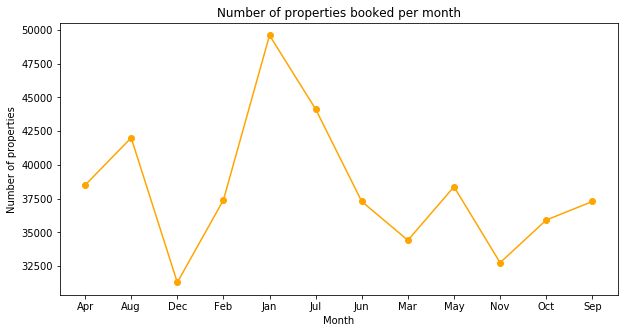

In [33]:
# Plot the number of listings available per month
plt.plot(monthly_bookings['month'], monthly_bookings['count'], color='orange', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of properties')
plt.title('Number of properties booked per month')
plt.show()

In [34]:
# Calculate number of listings available for booking per season
seasonal_bookings = calendar_booked.groupby(['season'])['date'].count().reset_index(name='count')
seasonal_bookings

,season,count
0,autumn,105974
1,spring,111310
2,summer,123443
3,winter,118301


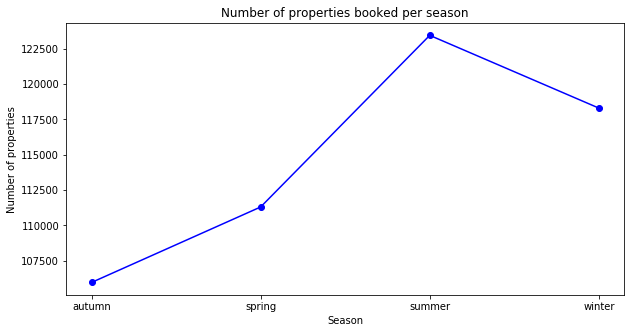

In [35]:
# Plot the number of listings available for booking per season
plt.plot(seasonal_bookings['season'], seasonal_bookings['count'], color='blue', marker='o')
plt.xlabel('Season')
plt.ylabel('Number of properties')
plt.title('Number of properties booked per season')
plt.show()

In [36]:
# Now that we have extracted all required information from the date column, we can drop it
# Also the column available can be dropped as all thr records have the value "t"
calendar.drop(['date', 'available'], axis=1, inplace=True)

In [37]:
calendar["target"] = np.log1p(calendar["target"]) # Normalise the highly skewed target column

Text(0.5, 0, 'Booking price')

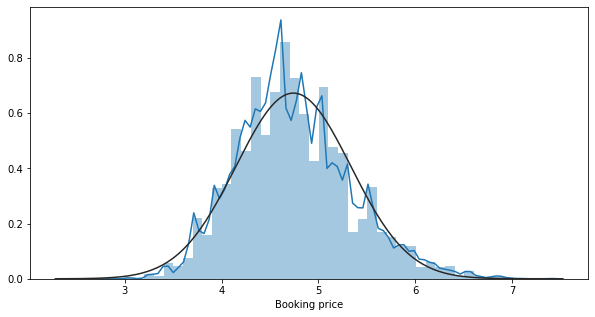

In [38]:
# Check for skewness in target data after normalising
sns.distplot(calendar['target'] , fit=norm);
plt.xlabel('Booking price')

In [39]:
# Extract all the categorical columns in the calendar dataset and create dummy columns for them
calendar_cat = calendar.select_dtypes(include=['object'])
calendar_cat.head()

cat_cols = calendar.select_dtypes(include=['object']).columns

dummies = pd.get_dummies(calendar_cat)
dummies.head()

,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_autumn,season_spring,season_summer,season_winter
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
14,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [40]:
# Drop the original ctegorical columns from the calendar dataset
for col in cat_cols:
    calendar.drop([col], axis=1, inplace=True)  

In [41]:
# Concatenate the calendar dataset and the dummies and store it as calendar_data
calendar_data = pd.concat([calendar, dummies], axis=1, sort=False)

calendar_data.head()

,listing_id,target,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,season_autumn,season_spring,season_summer,season_winter
0,241032,4.454347,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,241032,4.454347,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9,241032,4.454347,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
10,241032,4.454347,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
14,241032,4.454347,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


### Listings file:

In [42]:
listings.drop(['price'], axis=1, inplace=True) # Drop listing price as we are going to predict without this

In [43]:
# Convert host_response_rate to numeric and fill missing values with mode
listings['host_response_rate']  = listings['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
hrr_mode = listings['host_response_rate'].mode()[0]
listings['host_response_rate'] = listings['host_response_rate'].fillna(hrr_mode)

In [44]:
# Convert host_acceptance_rate to numeric and fill missing values with mode
listings['host_acceptance_rate']  = listings['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)
har_mode = listings['host_acceptance_rate'].mode()[0]
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].fillna(har_mode)

In [45]:
# Fill null values for host_response_time with mode
hrt_mode = listings['host_response_time'].mode()[0]
listings['host_response_time'] = listings['host_response_time'].fillna(hrt_mode)

In [46]:
# Fill null values for host_listings_count with mean and convert to numeric
hlc_mean = listings['host_listings_count'].mean()
listings['host_listings_count'] = listings['host_listings_count'].fillna(hlc_mean)
listings['host_listings_count'] = listings['host_listings_count'].astype('int')

In [47]:
# Fill null values for host_total_listings_count with mean and convert to numeric
htlc_mean = listings['host_total_listings_count'].mean()
listings['host_total_listings_count'] = listings['host_total_listings_count'].fillna(htlc_mean)
listings['host_total_listings_count'] = listings['host_total_listings_count'].astype('int')

In [48]:
# Create a mapping to convert 't' -> 1 and 'f' -> 0
map_t_f = {'t': 1, 'f': 0}

In [49]:
# Map host_identity_verified values from 't' -> 1 and 'f' -> 0
# Fill null values with 0 and convert to numeric
listings['host_identity_verified'] = listings['host_identity_verified'].map(map_t_f)
listings['host_identity_verified'] = listings['host_identity_verified'].fillna(0)
listings['host_identity_verified'] = listings['host_identity_verified'].astype('int')

In [50]:
# Map host_has_profile_pic values from 't' -> 1 and 'f' -> 0
# Fill null values with 0 and convert to numeric
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].map(map_t_f)
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].fillna(0)
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].astype('int')

In [51]:
# Map host_is_superhost values from 't' -> 1 and 'f' -> 0
# Fill null values with 0 and convert to numeric
listings['host_is_superhost'] = listings['host_is_superhost'].map(map_t_f)
listings['host_is_superhost'] = listings['host_is_superhost'].fillna(0)
listings['host_is_superhost'] = listings['host_is_superhost'].astype('int')

In [52]:
# Create a new column Transit_present which will have 1 if any transit information is available and 0 if nothing is available
listings['transit_present'] = 1
listings.loc[listings['transit'].isna(), 'transit_present'] = 0 
listings.drop(['transit'], axis=1, inplace=True) # Drop the transit column as we have created transit_present

In [53]:
# Fill null values for is_location_exact with mode
is_location_exact_mode = listings['is_location_exact'].mode()[0]
listings['is_location_exact'] = listings['is_location_exact'].fillna(is_location_exact_mode)

In [54]:
# Map is_location_exact values from 't' -> 1 and 'f' -> 0
listings['is_location_exact'] = listings['is_location_exact'].map(map_t_f)

In [55]:
# Fill null values with mean and convert 'bathrooms' to numeric
bathrooms_mean = listings['bathrooms'].mean()
listings['bathrooms'] = listings['bathrooms'].fillna(bathrooms_mean)
listings['bathrooms'] = listings['bathrooms'].astype('int')

In [56]:
# Fill null values with mean and convert 'bedrooms' to numeric
bedrooms_mean = listings['bedrooms'].mean()
listings['bedrooms'] = listings['bedrooms'].fillna(bedrooms_mean)
listings['bedrooms'] = listings['bedrooms'].astype('int')

In [57]:
# Fill null values with mean and convert 'beds' to numeric
beds_mean = listings['beds'].mean()
listings['beds'] = listings['beds'].fillna(beds_mean)
listings['beds'] = listings['beds'].astype('int')

In [58]:
# Fill null values with mode for 'property_type'
property_type_mode = listings['property_type'].mode()[0]
listings['property_type'] = listings['property_type'].fillna(property_type_mode)

In [59]:
# From the 'amenities' column, extract unique list of all amenities available in the listings data
amenities = []
for each in listings['amenities']:
    each = each.replace('{', '')
    each = each.replace('}', '')
    each = each.replace('"', '')
    list_of_amenities = each.split(',')
    for each in list_of_amenities:
        amenities.append(each)
        
amenities = set(amenities)
amenities = list(amenities)

amenities = [each for each in amenities if len(each) > 1]

amenities.sort()

In [60]:
# For all the extracted amenities, strip off white space, remove '(s)' and split into 2 if there is a '/' seperator
amenities_clean = []
for each in amenities:
    each = each.replace("(s)", '')
    each = each.split('/')
    for amenity in each:
        amenity = amenity.strip(' ')
        amenities_clean.append(amenity)

In [61]:
amenities_clean # Checking the list of amenities extracted and cleaned

['24-Hour Check-in',
 'Air Conditioning',
 'Breakfast',
 'Buzzer',
 'Wireless Intercom',
 'Cable TV',
 'Carbon Monoxide Detector',
 'Cat',
 'Dog',
 'Doorman',
 'Dryer',
 'Elevator in Building',
 'Essentials',
 'Family',
 'Kid Friendly',
 'Fire Extinguisher',
 'First Aid Kit',
 'Free Parking on Premises',
 'Gym',
 'Hair Dryer',
 'Hangers',
 'Heating',
 'Hot Tub',
 'Indoor Fireplace',
 'Internet',
 'Iron',
 'Kitchen',
 'Laptop Friendly Workspace',
 'Lock on Bedroom Door',
 'Other pet',
 'Pets Allowed',
 'Pets live on this property',
 'Pool',
 'Safety Card',
 'Shampoo',
 'Smoke Detector',
 'Smoking Allowed',
 'Suitable for Events',
 'TV',
 'Washer',
 'Washer',
 'Dryer',
 'Wheelchair Accessible',
 'Wireless Internet']

In [62]:
# Create a new column in the listings data for every amenity extracted and fill it 0 by default
for amenity in amenities_clean:
    listings[amenity] =  0

# For every record, fill the amanity column with 1 if that particular amenity is found in the existing 'amenities' column    
for amenity in amenities_clean:
    listings[amenity] = listings['amenities'].apply(lambda x: 1 if amenity in x else 0)        

In [63]:
# Create a numeric column 'total_amenities' which has the sum of amenities available in each property
listings['total_amenities'] = listings[amenities_clean].sum(axis=1)
listings['total_amenities'] = listings['total_amenities'].astype('int')

In [64]:
# Drop the original column 'amenities' as we have seperate columns per amenity
listings.drop(['amenities'], axis=1, inplace=True) 

In [65]:
listings.head(2)

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,transit_present,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer,Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat,Dog,Doorman,Dryer,Elevator in Building,Essentials,Family,Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Internet,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet,Pets Allowed,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Wheelchair Accessible,Wireless Internet,total_amenities
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96.0,100.0,0,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3,3,"['email', 'phone', 'reviews', 'kba']",1,1,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,1,Apartment,Entire home/apt,4,1,1,1,Real Bed,NaN,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,13
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98.0,100.0,1,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6,6,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,"7th Avenue West, Seattle, WA 98119, United States",

In [66]:
# Map t-> 1 and f-> 0 for the below columns
listings['has_availability'] = listings['has_availability'].map(map_t_f)
listings['requires_license'] = listings['requires_license'].map(map_t_f)
listings['instant_bookable'] = listings['instant_bookable'].map(map_t_f)
listings['require_guest_profile_picture'] = listings['require_guest_profile_picture'].map(map_t_f)
listings['require_guest_phone_verification'] = listings['require_guest_phone_verification'].map(map_t_f)

In [67]:
# Convert extra_people to numeric after replacing the '$' with nothing
listings['extra_people']  = listings['extra_people'].replace('[\$,]', '', regex=True).astype(float)
listings['extra_people'] = listings['extra_people'].astype('int')

In [68]:
# Find all columns which start with 'review_*' and drop them
review_cols = [c for c in listings.columns if 'review' in c]
review_cols

['number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [69]:
for col in review_cols:
    listings.drop([col], axis=1, inplace=True)

In [70]:
# Calculate the mean 'security_deposit' per neighbourhood and replace the nulls within the same neighbourhood with this calculated value
# Convert 'security_deposit' to numeric after removing the '$' sign

listings['security_deposit']  = listings['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
listings["security_deposit"] = listings.groupby("neighbourhood_group_cleansed")["security_deposit"].transform(
    lambda x: x.fillna(x.mean()))
listings['security_deposit'] = listings['security_deposit'].astype('int')

In [71]:
# Calculate the mean 'cleaning_fee' per neighbourhood and replace the nulls within the same neighbourhood with this calculated value
# Convert 'cleaning_fee' to numeric after removing the '$' sign
listings['cleaning_fee']  = listings['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
listings["cleaning_fee"] = listings.groupby("neighbourhood_group_cleansed")["cleaning_fee"].transform(
    lambda x: x.fillna(x.mean()))
listings['cleaning_fee'] = listings['cleaning_fee'].astype('int')

In [72]:
# Subset categorical data from the listings data
listings_cat = listings.select_dtypes(include=['object'])
listings_cat.head(2)

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,property_type,room_type,bed_type,weekly_price,monthly_price,calendar_updated,calendar_last_scraped,jurisdiction_names,cancellation_policy
0,https://www.airbnb.com/rooms/241032,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,"['email', 'phone', 'reviews', 'kba']","Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,Apartment,Entire home/apt,Real Bed,NaN,NaN,4 weeks ago,2016-01-04,WASHINGTON,moderate
1,https://www.airbnb.com/rooms/953595,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,"['email', 'phone', 'facebook', 'linkedin', 're...","7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,Apartment,Entire home/apt,Real Bed,"$1,000.00","$3,000.00",today,2016-01-04,WASHINGTON,strict


In [73]:
# Drop irrelevant columns

In [74]:
listings.drop(['scrape_id', 'last_scraped', 'listing_url', 'summary', 'square_feet', 'license'], axis=1, inplace=True)

In [75]:
listings.drop(['host_id', 'host_since', 'host_name', 'host_verifications', 'host_location', 'host_about'], axis=1, inplace=True)

In [76]:
listings.drop(['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'], axis=1, inplace=True)               

In [77]:
listings.drop(['name', 'space', 'description', 'notes', 'experiences_offered'], axis=1, inplace=True)

In [78]:
listings.drop(['neighborhood_overview', 'jurisdiction_names'], axis=1, inplace=True)

In [79]:
listings.drop(['city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'street'], axis=1, inplace=True)

In [80]:
listings.drop(['neighbourhood', 'host_neighbourhood'], axis=1, inplace=True)

In [83]:
listings.drop(['calendar_updated', 'calendar_last_scraped'], axis=1, inplace=True)
listings.drop(['monthly_price', 'weekly_price'], axis=1, inplace=True)
listings.drop(['host_acceptance_rate'], axis=1, inplace=True)

In [84]:
# Extract columns with float datatype
num_cols = listings.select_dtypes(include=['float'])
num_cols.head()

,host_response_rate
0,96.0
1,98.0
2,67.0
3,100.0
4,100.0


In [85]:
listings['host_response_rate'] = listings['host_response_rate'].astype('int') # Convert host_response_rate to int

In [86]:
# Create a new numerical column 'total_rooms' which is a sum of bedrooms and bathrooms 

listings['total_rooms'] = listings['bedrooms'] + listings['bathrooms']
listings['total_rooms'] = listings['total_rooms'].astype('int')

In [87]:
listings_cat = listings.select_dtypes(include=['object'])
listings_cat.head()

,host_response_time,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,bed_type,cancellation_policy
0,within a few hours,West Queen Anne,Queen Anne,Apartment,Entire home/apt,Real Bed,moderate
1,within an hour,West Queen Anne,Queen Anne,Apartment,Entire home/apt,Real Bed,strict
2,within a few hours,West Queen Anne,Queen Anne,House,Entire home/apt,Real Bed,strict
3,within an hour,West Queen Anne,Queen Anne,Apartment,Entire home/apt,Real Bed,flexible
4,within an hour,West Queen Anne,Queen Anne,House,Entire home/apt,Real Bed,strict


In [88]:
# ALl categorical column names present in listings dataset
cat_cols = listings.select_dtypes(include=['object']).columns
cat_cols

Index(['host_response_time', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bed_type', 'cancellation_policy'],
      dtype='object')

In [89]:
# Create dummies for all the categorical columns in the listings dataset
dummies = pd.get_dummies(listings_cat)
dummies.head()

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Delridge,neighbourhood_cleansed_South Lake Union,neighbourhood_cleansed_South Park,neighbourhood_cleansed_Southeast Magnolia,neighbourhood_cleansed_Stevens,neighbourhood_cleansed_Sunset Hill,neighbourhood_cleansed_University District,neighbourhood_cleansed_Victory Heights,neighbourhood_cleansed_View Ridge,neighbourhood_cleansed_Wallingford,neighbourhood_cleansed_Wedgwood,neighbourhood_cleansed_West Queen Anne,neighbourhood_cleansed_West Woodland,neighbourhood_cleansed_Westlake,neighbourhood_cleansed_Whittier Heights,neighbourhood_cleansed_Windermere,neighbourhood_cleansed_Yesler Terrace,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,proper

In [90]:
# Drop all the original categorical columns as we already have dummies created for them
for col in cat_cols:
    listings.drop([col], axis=1, inplace=True)

In [91]:
# Concatenate the listings dataset and the dummies created for the categorical columns
listings_data = pd.concat([listings, dummies], axis=1, sort=False)

In [92]:
listings_data.info() # Check column datatype summary to confirm that there is no non-numeric column left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 208 entries, listing_id to cancellation_policy_strict
dtypes: int32(14), int64(59), uint8(135)
memory usage: 2.4 MB


## 4. Data preparation

In [93]:
# Merge the listings and calendar datasets using 'listing_id'
df = pd.merge(listings_data, calendar_data, how='inner', on=['listing_id'])
df.head()

,listing_id,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,transit_present,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer,Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat,Dog,Doorman,Dryer,Elevator in Building,Essentials,Family,Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Internet,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet,Pets Allowed,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Wheelchair Accessible,Wireless Internet,total_amenities,total_rooms,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Delridge,neighbourhood_cleansed_South Lake Union,neighbourhood_cleansed_South Park,neighbourhood_cleansed_Southeast Magnolia,neighbourhood_cleansed_Stevens,neighbourhood_cleansed_Sunset Hill,neighbourhood_cleansed_University District,neighbourhood_cleansed_Victory Heights,neighbourhood_cleansed_

In [94]:
df.drop(['listing_id'], axis=1, inplace=True) # Drop listing_id as it hold no information for the prediction

#### Correlation between columns

In [95]:
# Create a correlation matrix that shows the correlation between the numeric variables
d_corr = df.select_dtypes(include=['int', 'float'])
corr = d_corr.corr()

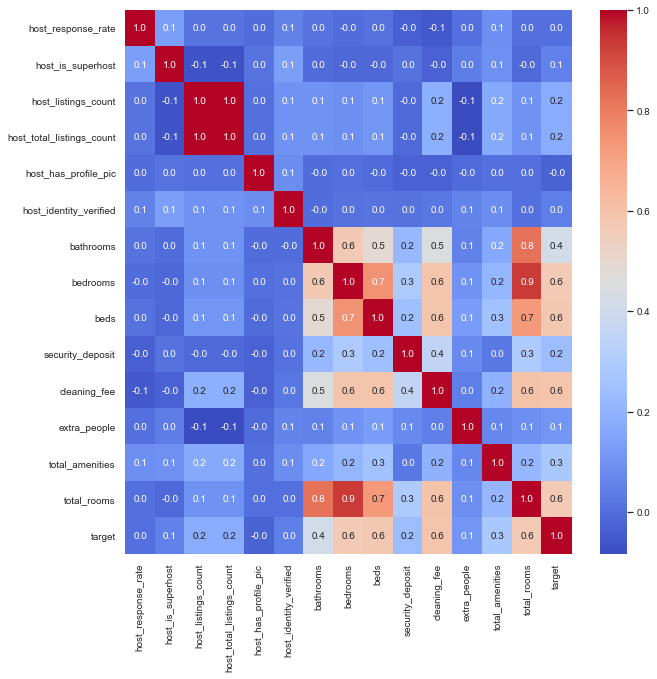

In [96]:
# heatmap which shows the correlation between the various numeric variables
plt.rcParams["figure.figsize"] = (10, 10)
sns.set(font_scale=0.9)
sns.heatmap(corr, cmap='coolwarm',  annot=True, fmt='.1f', annot_kws={"size": 10})

#### Splitting data to create train and test

In [97]:
y = df['target']
X = df.drop(['target'], axis=1)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 5. Model building and evaluation

#### Model 1: Linear Regression

In [99]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
y_pred_train_lr = lr_model.predict(X_train) # Predict for train dataset
y_pred_test_lr = lr_model.predict(X_test)  # Predict for test dataset

In [101]:
# Evaluation on train
# The mean squared error
print('Mean squared error on train: %.2f' % mean_squared_error(y_train, y_pred_train_lr))  
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination on train (R^2): %.2f' % r2_score(y_train, y_pred_train_lr))  
print('*****************')

# Evaluation on test
# The mean squared error
print('Mean squared error on test: %.2f' % mean_squared_error(y_test, y_pred_test_lr))  
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination on test (R^2): %.2f' % r2_score(y_test, y_pred_test_lr)) 

Mean squared error on train: 0.09
Coefficient of determination on train (R^2): 0.75
*****************
Mean squared error on test: 0.09
Coefficient of determination on test (R^2): 0.75


It looks like a strong linear relationship does not exist between the variables.

#### Model 2: Random Forest Regressor

In [102]:
random_forest_model = RandomForestRegressor(n_estimators=10)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [103]:
y_pred_train_rf = random_forest_model.predict(X_train) # Predict on train
y_pred_test_rf = random_forest_model.predict(X_test) # Predict on test

In [104]:
# Evaluation on train
# The mean squared error
print('Mean squared error on train: %.2f' % mean_squared_error(y_train, y_pred_train_rf))  
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination on train (R^2): %.2f' % r2_score(y_train, y_pred_train_rf))  
print('*****************')

# Evaluation on test
# The mean squared error
print('Mean squared error on test: %.2f' % mean_squared_error(y_test, y_pred_test_rf))  
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination on test (R^2): %.2f' % r2_score(y_test, y_pred_test_rf)) 

Mean squared error on train: 0.00
Coefficient of determination on train (R^2): 1.00
*****************
Mean squared error on test: 0.00
Coefficient of determination on test (R^2): 0.99


#### Find feature importance

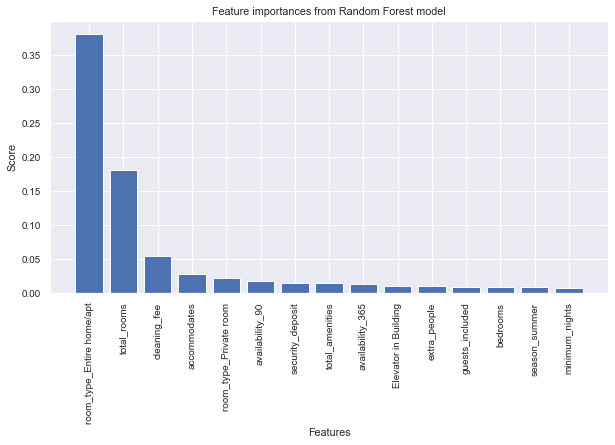

In [105]:
# The top 10 features as per the Random Forest model

headers = ["name", "score"]
values = sorted(zip(X_train.columns, random_forest_model.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = feature_importances['score'][:15]

# Plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center')
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances from Random Forest model')
plt.savefig('./feature importances.png')
plt.show()